# Full Cooling Calculation

We are now ready to demonstrate the full cooling calculation, starting from an injection of high-energy electrons and photons, and ending in an integrated ionization and thermal history that results from this injection. 

## Initialization

In [135]:
%load_ext autoreload
import sys
sys.path.append("..")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [396]:
%autoreload
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = [10,10]

import numpy as np
import pickle
import darkhistory.physics as phys
import darkhistory.spec.spectools as spectools
from darkhistory.spec.spectrum import Spectrum
import darkhistory.history.tla as tla

import darkhistory.low_energy.lowE_electrons as lowE_electrons
import darkhistory.low_energy.lowE_photons as lowE_photons
import time

np.set_printoptions(threshold=np.nan)

## Inputs

The inputs of the code are as follows: 

1. A `Spectrum` or `Spectra` object containing the injected electron spectrum, or the injected electron spectrum as a function of redshift, and/or 

2. A `Spectrum` or `Spectra` object containing the injected photon spectrum, or the injected photon spectrum as a function of redshift.

There are 3 modes of use. For a `Spectrum` input, the spectrum can be interpreted either as a single injection at a particular redshift, and no subsequent injections, or as a spectrum with the redshift dependence factored out, with a continuous injection at every step. For a `Spectra` input, the spectrum at each redshift step is injected. 

We will start with the single injection case here. As an example, we begin with a $\delta$-function injection of two 12 eV electrons at some arbitrary energy, start at redshift $1+z = 2000$. Let's first initialize the spectrum. 

In [615]:
###   Example: 24eV DM decaying into two 12eV photons   ###
rs0 = 2100
d_lnz = 1e-3
dt = d_lnz / phys.hubble(rs0)
m_DM = 2*12

#Energy injection through decay
def dm_injection_rate(rs):
    # Set the desired lifetime here in seconds. 
    tau = 1e19
    return phys.rho_DM*rs**3/tau

tot_inj = dm_injection_rate(rs0)

#Create a delta function spectrum at 12eV
bins = 200
eng = 10**((np.arange(bins)-.7*bins)*(10/bins))
DM_indx = spectools.get_indx(eng,m_DM/2)

eng=np.delete(eng,DM_indx)
eng=np.insert(eng,DM_indx,m_DM/2);

Ns = np.zeros(bins)
lowengelec_spec_final = Spectrum(eng, Ns, rs0, spec_type='N')
lowengphot_spec_final = Spectrum(eng, Ns, rs0, spec_type='N')

# Old Method

Given the final low energy electron and photon spectra, we can now calculate the fraction of energy that the electrons deposit in heating the IGM(?), lyman-$\alpha$ transitions, ionizing H, ionizing He, and continuum photons.

In [616]:
#The deposition rate is a constant function of z
dt = d_lnz / phys.hubble(rs0)
tot_inj = dm_injection_rate(rs0)
eng_inj = tot_inj * dt / (phys.nB * rs0**3)
lowengphot_spec_final.N[DM_indx] += 2 * eng_inj / m_DM
x = np.array([1, 0, 0])
num = lowE_photons.compute_dep_inj_ratio(lowengphot_spec_final, x , tot_inj, dt, method=Method)[1]
print(lowE_photons.compute_dep_inj_ratio(lowengphot_spec_final, x , tot_inj, dt, method=Method))

def f_H_exc(rs, xHI, xHeI, xHeII):
    return num

# All photons have been deposited
lowengphot_spec_final.N[DM_indx] = 0

(0.0, 0.99999999999999967, 0.0, 0, 0)


In [617]:
#t0 = time.time()
%prun

%autoreload
Method = "old"

# Redshifts at which the solution will be found
left = np.log(rs0) - np.floor(np.log(rs0)/d_lnz)*d_lnz
spacings = np.append(
    np.exp(np.flipud(np.arange(left,np.log(rs0)+d_lnz,d_lnz))),
    1
)

# Where the ionization and temperature histories will be stored
xe = np.zeros(len(spacings))
Ts = np.zeros(len(spacings))
f_hist = np.zeros(len(spacings))

# ionization and heating fractions are zero in this model
def f_H_ion(rs, xHI, xHeI, xHeII):
    return np.zeros_like(rs)

def f_heating(rs, xHI, xHeI, xHeII):
    return np.zeros_like(rs)

# Initial conditions
rs = rs0

T = phys.TCMB(rs)
Ts[0] = T

chi = phys.nHe/phys.nH
xHI = 0
xHII = 1-xHI
xHeI = chi
xHeII = 0
xHeIII = chi - xHeI - xHeII
xe[0] = xHII + xHeII + 2*xHeIII

t0 = time.time()
for k in np.arange(len(spacings)-1):
    init_cond = [T, xHII, xHeII, xHeIII]

    dt = d_lnz / phys.hubble(rs)
    tot_inj = dm_injection_rate(rs)
    eng_inj = tot_inj * dt / (phys.nB * rs**3)
    lowengphot_spec_final.N[DM_indx] += 2 * eng_inj / m_DM

    #def f_H_exc(rs, xHI, xHeI, xHeII):
        #x = np.array([xHI,xHeI,xHeII])
        #lowengphot_spec_final.rs = rs
        #return lowE_photons.compute_dep_inj_ratio(lowengphot_spec_final, x , tot_inj, dt, method=Method)[1]

    rs_new = spacings[k+1]
    rs_vec = np.array([rs, rs_new])

    if rs_new < 16.1:
        Reion_switch = False
    else:
        Reion_switch = False
            
    # Evaluation of the tla
    sol = tla.get_history(init_cond, f_H_ion, f_H_exc, f_heating, dm_injection_rate, rs_vec, reion_switch=Reion_switch)
    
    # All photons have been deposited
    lowengphot_spec_final.N[DM_indx] = 0
    
    #Update temperature and ionization fractions
    T, xHII, xHeII, xHeIII = sol[1]
    
    xHI = 1 - xHII
    xHeI = chi - xHeII - xHeIII
    xe[k+1] = xHII + xHeII + 2*xHeIII
    Ts[k+1] = T
    f_hist[k+1] = f_H_exc(rs, xHI, xHeI, xHeII)
    
    rs = rs_new
    
t1 = time.time()
print("Total Time: ", t1-t0)

Total Time:  29.296278953552246


In [606]:
Ts_noDM = Ts
xe_noDM = xe

In [622]:
Ts_old = Ts
xe_old = xe

[1, 3000.0, 0.0001, 2]

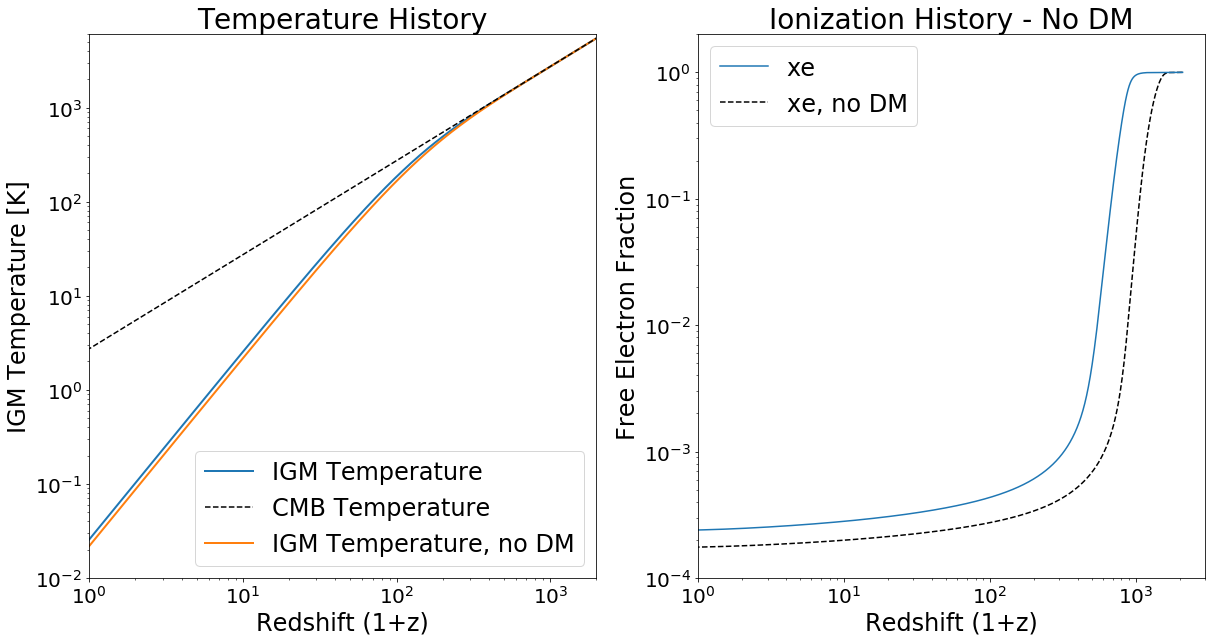

In [618]:
plt.figure(figsize=(20,10))

ax = plt.subplot(1,2,1)
#plt.rc('text', usetex=False)

T_IGM, = plt.plot(spacings, Ts/phys.kB, linewidth=2, label='IGM Temperature')
T_IGM_noDM, = plt.plot(spacings, Ts_noDM/phys.kB, linewidth=2, label='IGM Temperature, no DM')
T_CMB, = plt.plot(spacings, phys.TCMB(spacings)/phys.kB, 'k--', label='CMB Temperature')

ax.set_xscale('log')
ax.set_yscale('log')

plt.legend(handles=[T_IGM, T_CMB, T_IGM_noDM], 
           fontsize=24)

plt.tick_params(axis='both', which='major', labelsize=20)

plt.title('Temperature History', fontsize=28)
plt.xlabel('Redshift (1+z)',fontsize=24)
plt.ylabel('IGM Temperature [K]',fontsize=24)
plt.axis([1, 2e3, 1e-2, 6e3])

ax = plt.subplot(1,2,2)
#plt.rc('text', usetex=False)

xe_noDM_plt, = plt.plot(spacings, xe_noDM, 'k--', label='xe, no DM')
xe_DM_plt, = plt.plot(spacings, xe, label='xe')

ax.set_xscale('log')
ax.set_yscale('log')

plt.legend(handles=[xe_DM_plt, xe_noDM_plt], 
           fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=20)

plt.title('Ionization History - No DM', fontsize=28)
plt.xlabel('Redshift (1+z)',fontsize=24)
plt.ylabel('Free Electron Fraction',fontsize=24)
plt.axis([1, 3e3, 1e-4, 2])

In [621]:
print(Ts_noDM-Ts)

[  0.00000000e+00   6.27609076e-12   6.69519995e-12   6.71096512e-12
   8.34032843e-12   7.80636666e-12   7.60241869e-12   8.04822875e-12
   8.28087598e-12   9.00390873e-12   9.70246106e-12   1.03785314e-11
   1.13964949e-11   1.10218501e-11   1.20373711e-11   1.21913035e-11
   1.25193189e-11   1.37954093e-11   1.52478585e-11   1.38211109e-11
   1.46712642e-11   1.54792290e-11   1.70965464e-11   1.78181359e-11
   1.78119186e-11   1.83542070e-11   1.90287230e-11   1.99445460e-11
   2.07637796e-11   2.16789364e-11   2.25955366e-11   2.38269959e-11
   2.45033438e-11   2.45526932e-11   2.66722755e-11   2.77851075e-11
   2.89665514e-11   3.02011749e-11   3.17687543e-11   3.32170957e-11
   3.40755757e-11   3.50853790e-11   3.70652953e-11   3.96457311e-11
   4.04068445e-11   4.28496683e-11   4.34192127e-11   4.55250282e-11
   4.71005457e-11   4.92871299e-11   5.12775378e-11   5.34320921e-11
   5.55749891e-11   5.86645732e-11   6.07032757e-11   6.28575525e-11
   6.52222165e-11   6.82596202e-11

# New Method

Given the final low energy electron and photon spectra, we can now calculate the fraction of energy that the electrons deposit in heating the IGM(?), lyman-$\alpha$ transitions, ionizing H, ionizing He, and continuum photons.

In [687]:
rs0 = 2000
d_lnz = 1e-1
dt = d_lnz / phys.hubble(rs0)
m_DM = 2*12

#Energy injection through decay
def dm_injection_rate(rs):
    # Set the desired lifetime here in seconds. 
    tau = 1e19
    return phys.rho_DM*rs**3/tau

tot_inj = dm_injection_rate(rs0)

#Create a delta function spectrum at 12eV
bins = 200
eng = 10**((np.arange(bins)-.7*bins)*(10/bins))
DM_indx = spectools.get_indx(eng,m_DM/2)

eng=np.delete(eng,DM_indx)
eng=np.insert(eng,DM_indx,m_DM/2);

Ns = np.zeros(bins)
lowengelec_spec_final = Spectrum(eng, Ns, rs0, spec_type='N')
lowengphot_spec_final = Spectrum(eng, Ns, rs0, spec_type='N')

In [689]:
#t0 = time.time()
%prun

%autoreload
Method = "new"

# Redshifts at which the solution will be found
left = np.log(rs0) - np.floor(np.log(rs0)/d_lnz)*d_lnz
spacings = np.append(
    np.exp(np.flipud(np.arange(left,np.log(rs0)+d_lnz,d_lnz))),
    1
)

# Where the ionization and temperature histories will be stored
xe = np.zeros(len(spacings))
Ts = np.zeros(len(spacings))
f_hist = np.zeros(len(spacings))

# ionization and heating fractions are zero in this model
def f_H_ion(rs, xHI, xHeI, xHeII):
    return np.zeros_like(rs)

def f_heating(rs, xHI, xHeI, xHeII):
    return np.zeros_like(rs)

# Initial conditions
rs = rs0

T = phys.TCMB(rs)
Ts[0] = T

chi = phys.nHe/phys.nH
xHI = 0
xHII = 1-xHI
xHeI = chi
xHeII = 0
xHeIII = chi - xHeI - xHeII
xe[0] = xHII + xHeII + 2*xHeIII

t0 = time.time()
for k in [1,2]:#np.arange(len(spacings)-1):
    init_cond = [T, xHII, xHeII, xHeIII]

    dt = d_lnz / phys.hubble(rs)
    tot_inj = dm_injection_rate(rs)
    eng_inj = tot_inj * dt / (phys.nB * rs**3)
    lowengphot_spec_final.N[DM_indx] += 2 * eng_inj / m_DM
    
    f_hist[k] = f_H_exc(rs, xHI, xHeI, xHeII)

    def f_H_exc(rs, xHI, xHeI, xHeII):
        x = np.array([xHI,xHeI,xHeII])
        lowengphot_spec_final.rs = rs
        return lowE_photons.compute_dep_inj_ratio(lowengphot_spec_final, x , tot_inj, dt, method=Method)[1]

    rs_new = spacings[k+1]
    rs_vec = np.array([rs, rs_new])

    if rs_new < 16.1:
        Reion_switch = False
    else:
        Reion_switch = False
            
    # Evaluation of the tla
    sol = tla.get_history(init_cond, f_H_ion, f_H_exc, f_heating, dm_injection_rate, rs_vec, reion_switch=Reion_switch)
    lowengphot_spec_final.rs = spacings[k]
    
    #print('initial redshift ', lowengphot_spec_final.rs)
    #print(rs_new)
    # No photons deposit, all redshift
    lowengphot_spec_final.redshift(rs_new)
    
    #Update temperature and ionization fractions
    T, xHII, xHeII, xHeIII = sol[1]
    
    xHI = 1 - xHII
    xHeI = chi - xHeII - xHeIII
    xe[k+1] = xHII + xHeII + 2*xHeIII
    Ts[k+1] = T
    
    rs = rs_new
    
t1 = time.time()
print("Total Time: ", t1-t0)

 Total Time:  5.6431663036346436


In [686]:
#print(f_hist)
#print(lowengphot_spec_final.N)
#print(lowengphot_spec_final.N[DM_indx-2:DM_indx+2])
#lowengphot_spec_final.redshift(1000)
print(lowengphot_spec_final.N)
print(lowengphot_spec_final.N[DM_indx])

[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00

In [680]:
print(spacings)

[  2.00000000e+03   1.80967484e+03   1.63746151e+03   1.48163644e+03
   1.34064009e+03   1.21306132e+03   1.09762327e+03   9.93170608e+02
   8.98657928e+02   8.13139319e+02   7.35758882e+02   6.65742167e+02
   6.02388424e+02   5.45063586e+02   4.93193928e+02   4.46260320e+02
   4.03793036e+02   3.65367048e+02   3.30597776e+02   2.99137238e+02
   2.70670566e+02   2.44912857e+02   2.21606317e+02   2.00517687e+02
   1.81435907e+02   1.64169997e+02   1.48547156e+02   1.34411025e+02
   1.21620125e+02   1.10046440e+02   9.95741367e+01   9.00984048e+01
   8.15244080e+01   7.37663348e+01   6.67465399e+01   6.03947668e+01
   5.46474449e+01   4.94470529e+01   4.47415437e+01   4.04838229e+01
   3.66312778e+01   3.31453508e+01   2.99911536e+01   2.71371180e+01
   2.45546798e+01   2.22179931e+01   2.01036715e+01   1.81905542e+01
   1.64594941e+01   1.48931661e+01   1.34758940e+01   1.21934931e+01
   1.10331288e+01   9.98318781e+00   9.03316189e+00   8.17354288e+00
   7.39572743e+00   6.69193091e+00

In [606]:
Ts_noDM = Ts
xe_noDM = xe

In [622]:
Ts_old = Ts
xe_old = xe

ValueError: x and y must have same first dimension, but have shapes (78,) and (7651,)

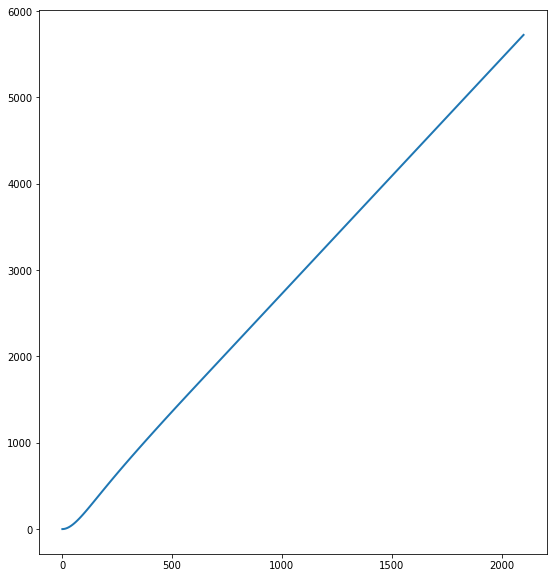

In [627]:
plt.figure(figsize=(20,10))

ax = plt.subplot(1,2,1)
#plt.rc('text', usetex=False)

T_IGM, = plt.plot(spacings, Ts/phys.kB, linewidth=2, label='IGM Temperature')
T_IGM_noDM, = plt.plot(spacings, Ts_noDM/phys.kB, linewidth=2, label='IGM Temperature, no DM')
T_CMB, = plt.plot(spacings, phys.TCMB(spacings)/phys.kB, 'k--', label='CMB Temperature')

ax.set_xscale('log')
ax.set_yscale('log')

plt.legend(handles=[T_IGM, T_CMB, T_IGM_noDM], 
           fontsize=24)

plt.tick_params(axis='both', which='major', labelsize=20)

plt.title('Temperature History', fontsize=28)
plt.xlabel('Redshift (1+z)',fontsize=24)
plt.ylabel('IGM Temperature [K]',fontsize=24)
plt.axis([1, 2e3, 1e-2, 6e3])

ax = plt.subplot(1,2,2)
#plt.rc('text', usetex=False)

xe_noDM_plt, = plt.plot(spacings, xe_noDM, 'k--', label='xe, no DM')
xe_DM_plt, = plt.plot(spacings, xe, label='xe')

ax.set_xscale('log')
ax.set_yscale('log')

plt.legend(handles=[xe_DM_plt, xe_noDM_plt], 
           fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=20)

plt.title('Ionization History - No DM', fontsize=28)
plt.xlabel('Redshift (1+z)',fontsize=24)
plt.ylabel('Free Electron Fraction',fontsize=24)
plt.axis([1, 3e3, 1e-4, 2])

# Scratch Work

In [383]:
rs_vec[rs_vec > 16.1]

array([ 3000.       ,  2997.0014995])

In [ ]:
%autoreload
import darkhistory.low_energy.lowE_photons as lowE_photons
Method = "new"
x = np.array([xHI,xHeI,xHeII])
tmp=lowE_photons.compute_dep_inj_ratio(lowengphot_spec_final, x , tot_inj, dt, method=Method)
dLam_dnu = phys.get_dLam2s_dnu()
print(tmp)

In [335]:
from scipy import integrate
T = phys.TCMB(rs0)
def Boltz(E):
    return np.exp(-E/phys.kB/T)
def E_Boltz(E):
    return E*np.exp(-E/phys.kB/T)


#Ns = np.array([integrate.quad(Boltz,low,high)[0] for low,high in zip(tmp[:-1], tmp[1:])])

#CMB_spec = Spectrum(eng, Ns, rs0, spec_type='N')
#print(sum(CMB_spec.N),integrate.quad(Boltz,tmp[0],tmp[400]),phys.kB*T*(Boltz(tmp[0])-Boltz(tmp[400])))


bounds=spectools.get_bin_bound(eng)

point = spectools.get_indx(bounds, phys.lya_eng-eng[0])
#print(point)
mid = spectools.get_indx(bounds, phys.lya_eng/2)
complement = np.zeros(mid)
f_nu = lowengphot_spec_final.dNdE * phys.c**3 / (8 * np.pi * (eng/phys.hbar)**2)

for k in np.arange(mid):
    while (phys.lya_eng - eng[k]) < bounds[point]:
        point -= 1
    complement[k] = f_nu[point]
        #indices[k] = point
            
print(bounds[mid],bounds[mid+1])
#print(np.nonzero(complement))
#print(phys.lya_eng - eng[np.nonzero(complement)],phys.lya_eng - eng[603],bounds[801],bounds[802])
#print(tmp[775:803])
#print(eng[775],tmp[775],tmp[776])


5.06990708275 5.18800038929


In [336]:
diffs = (np.append(bounds[1:mid],phys.lya_eng/2)-np.insert(bounds[1:mid],0,0))/(2*np.pi*phys.hbar)
Lam = phys.get_dLam2s_dnu()
rates = Lam(eng[:mid]/(2 * np.pi * phys.hbar))
print(np.sum(rates*diffs),phys.lya_eng/2)
print(np.sum(diffs)/phys.lya_freq)
print(integrate.quad(Lam,0,phys.lya_freq/2)[0])

boltz = Boltz(eng[:mid])
boltz_complement = Boltz(phys.lya_eng - eng[:mid])

#Numerical Integral
np.sum(
    diffs*(f_nu[:mid] + boltz)*(complement[:mid] + boltz_complement) * rates
)/phys.width_2s1s-Boltz(phys.lya_eng)

8.22994013092 5.1021346987500005
0.5
8.230000000000272


0.0

21.425235664750588
21.3312464137


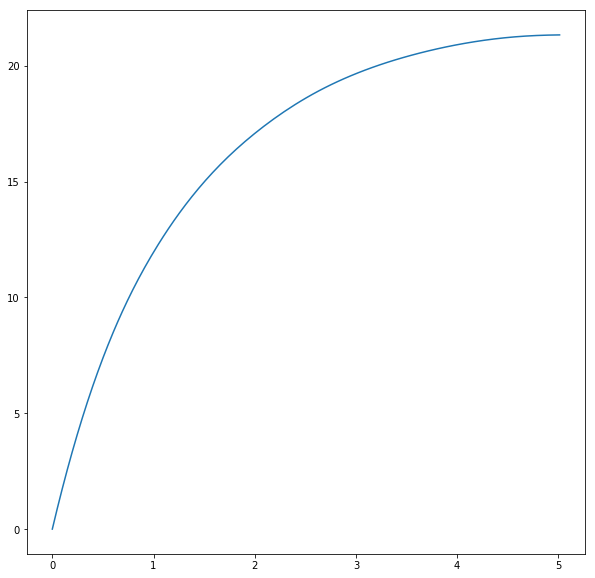

In [329]:
plt.plot(eng[:mid],rates)
print(9*phys.alpha**6 * phys.rydberg / (2**10 * 2 * np.pi * phys.hbar) * 4.907)
print(rates[mid-1])
#plt.plot()
plt.show()

In [333]:
%autoreload
eng = 10**((np.arange(1000)-300)*(1/100))
import matplotlib.pyplot as plt
import darkhistory.spec.spectools as spectools
T=300
beta = 1/T/phys.kB
def f_EQ(eng, beta):
    return np.exp(-beta*eng)
tmp_spec = spectools.discretize(eng,f_EQ,beta)
h = 2 * np.pi * phys.hbar
right=spectools.get_indx(eng,phys.lya_eng)
f_E = tmp_spec.dNdE[:right]
#print(f_E*np.flip(f_E,0) * np.exp(beta*phys.lya_eng))
#plt.plot(eng[indx:],f_EQ(eng[indx:],T),'r--',eng[indx:],tmp_spec.dNdE[indx:],'g^')

In [62]:
tmp=np.delete(eng,indx)
tmp=np.insert(tmp,indx,m_DM/2);
print(tmp[indx-1:indx+2])
print(eng[indx-1:indx+2])

[ 10.96478196  11.2         11.48153621]
[ 10.96478196  11.22018454  11.48153621]


In [56]:
# WORRIES: (1) These f_c(z) functions are not optimized
#          (2) I have switched from xe to xHII
#          (3) Both compute_dep_inj_ratio functions assume that Spectrum.N returns number density per unit time
#          (4) lowE_photons.compute_dep_inj_ratio needs [n_H,n_HeI,n_HeII] as input, not x_HII.
#          (5) Can photons contribute to heating?  Heating of what, IGM?

rs0=3000
rs_final = 1
xHII = .5
xHeI = 0
xHeII = 0
Method = "ion"

def f_H_ion(rs, xHI, xHeI, xHeII):
    n = np.array([xHI,xHeI,xHeII])*phys.nH*(rs**3)
    photon = lowE_photons.compute_dep_inj_ratio(lowengphot_spec_final, n, tot_inj, method=Method)[2]
    electron = lowE_electrons.compute_dep_inj_ratio(lowengelec_spec_final, xHII, tot_inj)[2]
    return electron + photon

def f_H_exc(rs, xHI, xHeI, xHeII):
    n = np.array([xHI,xHeI,xHeII])*phys.nH*(rs**3)
    photon = lowE_photons.compute_dep_inj_ratio(lowengphot_spec_final, n , tot_inj, method=Method)[1]
    electron = lowE_electrons.compute_dep_inj_ratio(lowengelec_spec_final, xHII, tot_inj)[1]
    return electron + photon

def f_heating(rs, xHI, xHeI, xHeII):
    return lowE_electrons.compute_dep_inj_ratio(lowengelec_spec_final, xHII, tot_inj)[0]

# Initialize the redshift at which we want the solution. 
rs_vec = np.flipud(1 + np.arange(rs_final,rs0,1))

# Set the initial conditions. The initial temperature is the CMB temperature, 
# and the initial free electron fraction is 1. Strictly speaking, the code
# changes 1 to 1 - 1e-12, as otherwise y is infinite.
init_cond = [phys.TCMB(rs0), 1, 0, 0]

# Obtain the solution
soln = tla.get_history(init_cond, f_H_ion, f_H_exc, f_heating, dm_injection_rate, rs_vec, reion_switch=False)
print(soln[-10:,0]/phys.kB)

[  3295.87724568   3808.57837014   4460.35722941   5307.87614393
   6440.16805266   8003.39975759  10249.97632068  13640.62994315
  19058.98657169  28198.62910868]


[1, 3000.0, 0.0001, 2]

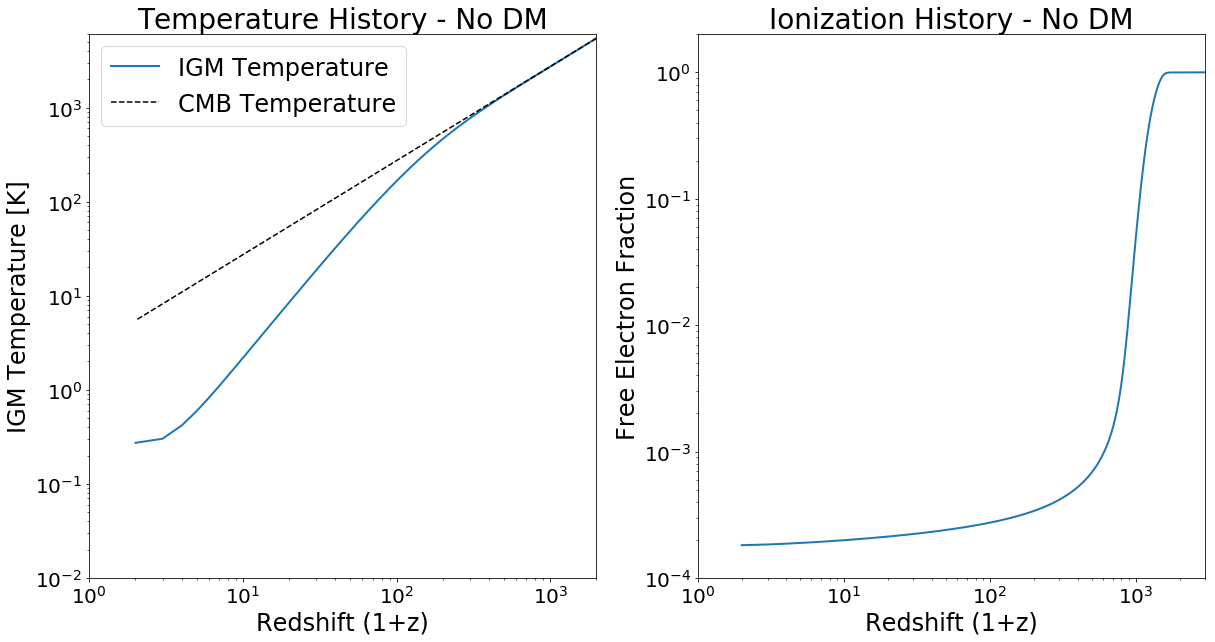

In [19]:
plt.figure(figsize=(20,10))

ax = plt.subplot(1,2,1)
#plt.rc('text', usetex=False)

T_IGM, = plt.plot(rs_vec, soln[:,0]/phys.kB, linewidth=2, label='IGM Temperature')
T_CMB, = plt.plot(rs_vec, phys.TCMB(rs_vec)/phys.kB, 'k--', label='CMB Temperature')

ax.set_xscale('log')
ax.set_yscale('log')

plt.legend(handles=[T_IGM, T_CMB], 
           fontsize=24)

plt.tick_params(axis='both', which='major', labelsize=20)

plt.title('Temperature History - No DM', fontsize=28)
plt.xlabel('Redshift (1+z)',fontsize=24)
plt.ylabel('IGM Temperature [K]',fontsize=24)
plt.axis([1, 2e3, 1e-2, 6e3])

ax = plt.subplot(1,2,2)
#plt.rc('text', usetex=False)

plt.plot(rs_vec, soln[:,1], linewidth=2)

ax.set_xscale('log')
ax.set_yscale('log')

plt.tick_params(axis='both', which='major', labelsize=20)

plt.title('Ionization History - No DM', fontsize=28)
plt.xlabel('Redshift (1+z)',fontsize=24)
plt.ylabel('Free Electron Fraction',fontsize=24)
plt.axis([1, 3e3, 1e-4, 2])